# CNN with CUDA in fashion MNIST

## Julian Ariza

Importing of libraries and CUDA verification.

In [1]:
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt
torch.cuda.is_available()
device = torch.device('cuda:0')

In [2]:
device

device(type='cuda', index=0)

In [3]:
def show_data(data_sample, classes = [] , shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray')
    plt.title('y = ' + classes[data_sample[1]])
    plt.show()

## Dataset Object Creation

In [4]:
train_dataset = dsets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = dsets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [5]:
print("Print the training dataset:\n ", train_dataset)

Print the training dataset:
  Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [6]:
print("Print the testing dataset:\n ", test_dataset)

Print the testing dataset:
  Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [7]:
classes = train_dataset.classes

## A look to the dataset

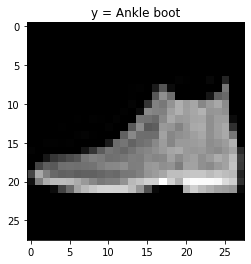

In [8]:
show_data(test_dataset[0], classes)

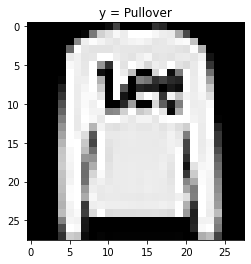

In [9]:
show_data(test_dataset[1], classes)

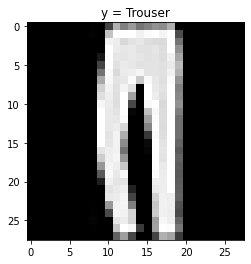

In [10]:
show_data(test_dataset[2], classes)

In [11]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


## Creation of CNN with batch normalization

It contains two convolution layers with max polling, and one fully conected layer of neurons.

In [12]:
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(number_of_classes)
    
    # Prediction
    def forward(self, x):
        #print('As in: ', x.size())
        x = self.cnn1(x)
        #print('After cnn1: ', x.size())
        x=self.conv1_bn(x)
        #print('After bn1: ', x.size())
        x = torch.relu(x)
        #print('After relu: ', x.size())
        x = self.maxpool1(x)
        #print('After pool1: ', x.size())
        x = self.cnn2(x)
        #print('After cnn2: ', x.size())
        x=self.conv2_bn(x)
        #print('After bn: ', x.size())
        x = torch.relu(x)
        #print('After relu: ', x.size())
        x = self.maxpool2(x)
        #print('After pool2: ', x.size())
        x = x.view(x.size(0), -1)
        #print('After view: ', x.size())
        x = self.fc1(x)
        #print('After fc1: ', x.size())
        x=self.bn_fc1(x)
        #print('After bn3: ', x.size())
        return x

In [13]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):
    
    #global variable 
    N_test=len(test_dataset)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
        loss_list.append(loss.data)

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

## RESULTS

Without CUDA the time was arounf 460 seconds.

In [14]:
import datetime
a = datetime.datetime.now()
model_batch=CNN_batch(out_1=16, out_2=32)
model_batch = model_batch.to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_batch.parameters(), lr = learning_rate)
trainloader = DataLoader(dataset = train_dataset, batch_size = 100)
testloader = DataLoader(dataset = test_dataset, batch_size = 5000)
accuracy_list_batch, loss_list_batch=train_model(model=model_batch,n_epochs=10,train_loader=trainloader,validation_loader=testloader,optimizer=optimizer)
b = datetime.datetime.now()
c = b-a
print(c.seconds)

123


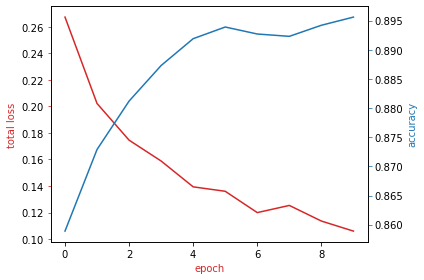

In [15]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list_batch,color=color)
ax1.set_ylabel('total loss',color=color)
ax1.set_xlabel('epoch',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.plot(accuracy_list_batch, color=color)
ax2.set_ylabel('accuracy', color=color)  
ax2.set_xlabel('epoch',color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()